# Amazon Luxury Beauty Recommender

***Overview***

Recommender systems have changed the game for online retailers. Companies like Amazon have increased sales by suggesting new and exciting products to their users. But just recommending any old product isn't going to yield the most desired results. 

The recommendations need to be relevent to convince the customer to hit that checkout button.

There are a variety of ways to take data from products and users and make recommendation. In this project, collaborative filtering, will be the method used to predict ratings and give recommendatinons.

***Table of Contents***


1.   Import Libraries and Packages
2.   Load and PreProcess Data Sets

      *   Review Data
      *   Meta-Data
3.   Merge Data for Exploration
4.   EDA of Product Titles
5.   EDA of Review Data
6.   Final Processing for Model Phase




Data Citation:

Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering

***R. He, J. McAuley WWW, 2016***






# Import Libraries

In [0]:
#Install Java and Apache Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [2]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 217.8MB 21kB/s 
     |████████████████████████████████| 204kB 54.6MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=88621e4b6db493dfc086662a212b9edab115a8b977de7275218c8c7633a40f05
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [4]:
# Point Colaboratory to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
import json
import gzip
import pandas as pd
import numpy as np
import functools

from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import isnan, when, count, col, countDistinct
from pyspark.sql.functions import monotonically_increasing_id


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATA_NAME = '/content/gdrive/My Drive/Luxury_Beauty_5.json.gz'
APP_NAME = "Review Data"
SPARK_URL = "local[*]"
MAX_MEMORY = "6g"

In [0]:
#Create spark context and sqlcontext
sc = SparkSession.builder.appName(APP_NAME).config('spark.driver.memory', MAX_MEMORY).config('spark.driver.memory', MAX_MEMORY).master(SPARK_URL).getOrCreate()
sc.sparkContext.setCheckpointDir('/tmp')
sqlContext = SQLContext(sc)



# Load and Examine Datasets



### Review Data
The review dataset has been previously filtered to contain users with more than 5 reviews and products with 5 or more reviews.

Load and examine the columns in the dataset containing the ratings from Amazon users



In [0]:
#Load the review dataset
reviews = sqlContext.read.json(DATA_NAME)

In [11]:
print(f"Dataset shape is {reviews.count():d} rows by {len(reviews.columns):d} columns.")

Dataset shape is 34278 rows by 12 columns.


In [12]:
reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Flavor Name:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Quantity:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Scent Name:: string (nullable = true)
 |    |-- Scent:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = tru

In [0]:
reviews.registerTempTable('revs')

In [14]:
#View the first 20 rows of data
sqlContext.sql("select * from revs").show()

+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|   reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+---------------+--------------------+--------------------+--------------+--------+----+
|B00004U9V2| null|    5.0|This handcream ha...| 01 5, 2018|A2HOI48JK8838M|             DB|[,,,,,,,,  0.9 oz...| Beautiful Fragrance|    1515110400|    true|null|
|B00004U9V2| null|    5.0|wonderful hand lo...| 04 5, 2017|A1YIPEY7HX73S7|          Ajaey|[,,,,,,,,  3.5 oz...|wonderful hand lo...|    1491350400|    true|null|
|B00004U9V2| null|    5.0|Best hand cream a...|03 27, 2017|A2QCGHIJ2TCLVP|       D. Jones| [,,,,,,,,  250 g,,]|Best hand cream a...|    1490572800|    true|null|
|B00004U9V2| null|    5.0|  

In [15]:
#Drop duplicate reviews
reviews = reviews.dropDuplicates()
reviews.count()

30313

In [16]:
#Check for missing values
reviews.select([count(when(col(c).isNull(), c)).alias(c) for c in reviews.columns]).show()

+----+-----+-------+----------+----------+----------+------------+-----+-------+--------------+--------+-----+
|asin|image|overall|reviewText|reviewTime|reviewerID|reviewerName|style|summary|unixReviewTime|verified| vote|
+----+-----+-------+----------+----------+----------+------------+-----+-------+--------------+--------+-----+
|   0|29722|      0|        10|         0|         0|           0|14266|     15|             0|       0|25527|
+----+-----+-------+----------+----------+----------+------------+-----+-------+--------------+--------+-----+



In [0]:
#Select relevant columns from review dataframe
reviews = reviews.select('asin', 'overall', 'reviewerID').withColumnRenamed(
    'asin', 'productID').withColumnRenamed('overall', 'rating')

In [18]:
reviews.show(5)

+----------+------+--------------+
| productID|rating|    reviewerID|
+----------+------+--------------+
|B00004U9V2|   5.0|A1606LA683WZZU|
|B000142FVW|   3.0| AUFJRMYL1K9OZ|
|B00014GT8W|   5.0|A2HZ3Z494VS1KG|
|B00014GT8W|   5.0|A23WE733QT4WGJ|
|B00014GT8W|   3.0|A2MUGFV2TDQ47K|
+----------+------+--------------+
only showing top 5 rows



### Meta-Data 


The review data does not contain any information about the products aside from the product ID. The meta-data will provide information about the products and to give recommendations with a title, as opposed to just a product ID. 



In [0]:
#Load the meta_data 
meta_data = sqlContext.read.json('/content/gdrive/My Drive/meta_Luxury_Beauty.json.gz')

In [20]:
print(f"Dataset shape is {meta_data.count():d} rows by {len(meta_data.columns):d} columns.")

Dataset shape is 12308 rows by 12 columns.


In [21]:
meta_data.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- feature: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_cat: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- title: string (nullable = true)



The data source gives a suggestion for cleaning the meta-data. Some rows are not formatted correctly and contain html code in the title column.



In [0]:
#filter out unformated rows
meta_data = meta_data.filter(~meta_data.title.contains('getTime'))

In [23]:
meta_data.count()

12078

In [0]:
meta_data.registerTempTable('products')

In [25]:
sqlContext.sql('select * from products').show(5)

+--------------------+--------------------+----------+-----+--------------------+--------------------+-------+--------------------+-------------+------+--------------------+--------------------+
|            also_buy|           also_view|      asin|brand|         description|             details|feature|               image|     main_cat| price|                rank|               title|
+--------------------+--------------------+----------+-----+--------------------+--------------------+-------+--------------------+-------------+------+--------------------+--------------------+
|[B00GHX7H0A, B00F...|[B00FRERO7G, B00G...|B00004U9V2| null|[After a long day...|
  <div class="co...|   null|[https://images-n...|Luxury Beauty|$30.00|4,324inBeautyPers...|Crabtree & Evelyn...|
|                null|                null|B0000531EN| null|[If you haven't e...|
  <div class="co...|   null|                null|Luxury Beauty|  null|1,633,549inBeauty...|    AHAVA Bath Salts|
|                null|   

In [26]:
meta_data.select([count(when(col(c).isNull(), c)).alias(c) for c in meta_data.columns]).show()

+--------+---------+----+-----+-----------+-------+-------+-----+--------+-----+----+-----+
|also_buy|also_view|asin|brand|description|details|feature|image|main_cat|price|rank|title|
+--------+---------+----+-----+-----------+-------+-------+-----+--------+-----+----+-----+
|    4473|     3180|   0|12066|        147|      3|  12075| 1991|       0| 5224|  97|    0|
+--------+---------+----+-----+-----------+-------+-------+-----+--------+-----+----+-----+



In [0]:
#Select relevent columns
meta_data = meta_data.select('asin', 'title' ).withColumnRenamed(
    'asin', 'productID')

In [28]:
meta_data.show(3)

+----------+--------------------+
| productID|               title|
+----------+--------------------+
|B00004U9V2|Crabtree & Evelyn...|
|B0000531EN|    AHAVA Bath Salts|
|B0000532JH|AHAVA Dead Sea Mi...|
+----------+--------------------+
only showing top 3 rows



# Merging Review and Meta-Data Dataframes

In [0]:
#combine review data and product data
review_data = reviews.join(meta_data, on='productID', how='inner')

In [62]:
review_data.count()

31051

In [63]:
#Check for missing values
review_data.select([count(when(col(c).isNull(), c)).alias(c) for c in review_data.columns]).show()

+---------+------+----------+-----+
|productID|rating|reviewerID|title|
+---------+------+----------+-----+
|        0|     0|         0|    0|
+---------+------+----------+-----+



In [64]:
ratings_with_titles = ratings_with_titles.dropDuplicates()
ratings_with_titles.count()

27823

In [33]:
#Double check that no values are missing
ratings_with_titles.select([count(when(col(c).isNull(), c)).alias(c) for c in ratings_with_titles.columns]).show()

+---------+------+----------+-----+
|productID|rating|reviewerID|title|
+---------+------+----------+-----+
|        0|     0|         0|    0|
+---------+------+----------+-----+



# Exploratory Data Analysis- Product Titles

In [65]:
text_data = ratings_with_titles.select('title')
text_data.show()

+--------------------+
|               title|
+--------------------+
|OPI Nail Lacquer,...|
|OPI Nail Lacquer,...|
|OPI Nail Lacquer,...|
|OPI Nail Lacquer,...|
|Dermablend Cover ...|
|Baxter of Califor...|
|Jack Black Double...|
|jane iredale Pure...|
|Jouer Hydrating L...|
|Jurlique Moisture...|
|TOPPIK Hair Build...|
|TOPPIK Hair Build...|
|JACK BLACK – Indu...|
|ZOYA Nail Polish,...|
|essie Nail Color ...|
|Dermablend Compac...|
|MERKUR Futur Adju...|
|HOT TOOLS Profess...|
|essie Nail Color ...|
|   blinc Lash Primer|
+--------------------+
only showing top 20 rows



In [66]:
#convert text to pandas dataframe
product_text = text_data.toPandas()
product_text.drop_duplicates(subset='title', inplace=True)
product_text.head()

,title
0,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0..."
3,"OPI Nail Lacquer, She's a Bad Muffuletta!, 0.5..."
4,Dermablend Cover Creme Full Coverage Foundatio...
5,"Baxter of California Daily Protein Shampoo, 10..."
6,Jack Black Double-Duty Face Moisturizer SPF 20


### Cleaning Text Data


*   Lowercase
*   Remove punctuation
*   Remove numbers






In [0]:
product_text['title'] = product_text['title'].apply(lambda x:(x.lower()))

In [0]:
def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

In [0]:
import string
product_text['title'] = product_text['title'].apply(lambda x: remove_punctuation(x))

In [0]:
product_text['title'] = product_text['title'].str.replace('\d+', '')

In [71]:
product_text.head()

,title
0,opi nail lacquer not so boraboraing pink fl oz
3,opi nail lacquer shes a bad muffuletta fl oz
4,dermablend cover creme full coverage foundatio...
5,baxter of california daily protein shampoo fl oz
6,jack black doubleduty face moisturizer spf


# WordCloud

In [0]:
text = " ".join(product for product in product_text.title)

In [0]:
stopwords = set(STOPWORDS)
stopwords.update(['oz', 'ounce', 'fl', 'la','de'])

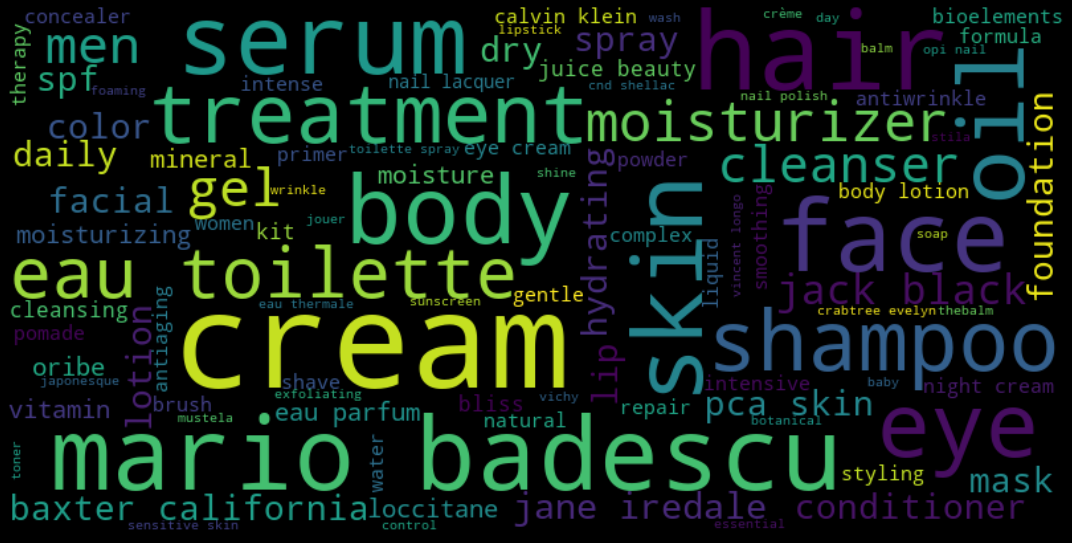

In [74]:
wordcloud = WordCloud(stopwords = stopwords, max_font_size=100, max_words=100, width=800, height=400, background_color="black").generate(text)
plt.figure(figsize=(15,25),
            facecolor = 'k',
            edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout()
plt.show()

                                                                       

---



The word cloud confirms that the products contian luxury beauty products.

# K-means Clustering 

In [75]:
#define the data to be used for clustering
data = product_text['title']
data.head()

0      opi nail lacquer not so boraboraing pink  fl oz
3        opi nail lacquer shes a bad muffuletta  fl oz
4    dermablend cover creme full coverage foundatio...
5    baxter of california daily protein shampoo  fl oz
6          jack black doubleduty face moisturizer spf 
Name: title, dtype: object

In order to cluster the products using the text from their titles, the column of words are vectorized, normalized and saved to an array. 

In [76]:
#Define the transformer
tfidf_vec = TfidfVectorizer(stop_words = stopwords, max_features = 5000)

#Transform the data
tf_idf = tfidf_vec.fit_transform(data)

#Normalize the data
tf_idf_norm = normalize(tf_idf)

#Convert into an array
tf_idf_array = tf_idf_norm.toarray()

#Visualize the array by converting to a pandas dataframe
pd.DataFrame(tf_idf_array, columns=tfidf_vec.get_feature_names()).head()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abba,abomb,abright,absence,absolute,absorbs,ac,acai,acandi,accelerator,accessories,acd,aching,acid,acids,acne,acqua,actif,acting,action,activated,active,adds,ade,adjustable,advanced,advancedc,affair,aftershave,ag,agave,age,agedefying,ageless,aggressors,aha,ahabha,ahava,air,airlines,...,whitens,whitesilver,wild,wildflowerchamomile,willowherb,winter,wipes,wisteria,witch,wless,wmini,women,womens,wood,woody,working,workouts,wow,wowimpact,wrinkle,wrinkles,xentan,xoxo,xpress,xtreme,xzem,yellowing,yeux,yogi,york,younger,youth,youthful,yube,zenith,zinc,zirh,zoya,zp,zwilling
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Elbow Plot

Create an elbow plot in order to visualize the ideal number of clusters. 

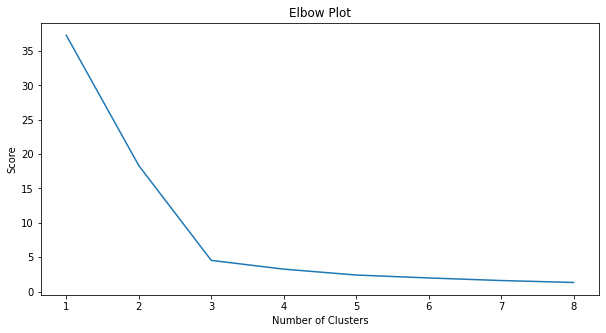

In [77]:
pca = PCA(n_components = 2)
y = pca.fit_transform(tf_idf_array)

number_clusters = range(1, 9)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.figure(figsize=(10, 5))
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Plot')
plt.show()

The elbow plot shows a sharp change in steepnes at 3 clusters, but continues to flatten out around 4 or 5 as well. 

# K-means Clusters




## Three Clusters

CPU times: user 28 ms, sys: 657 µs, total: 28.7 ms
Wall time: 28.3 ms


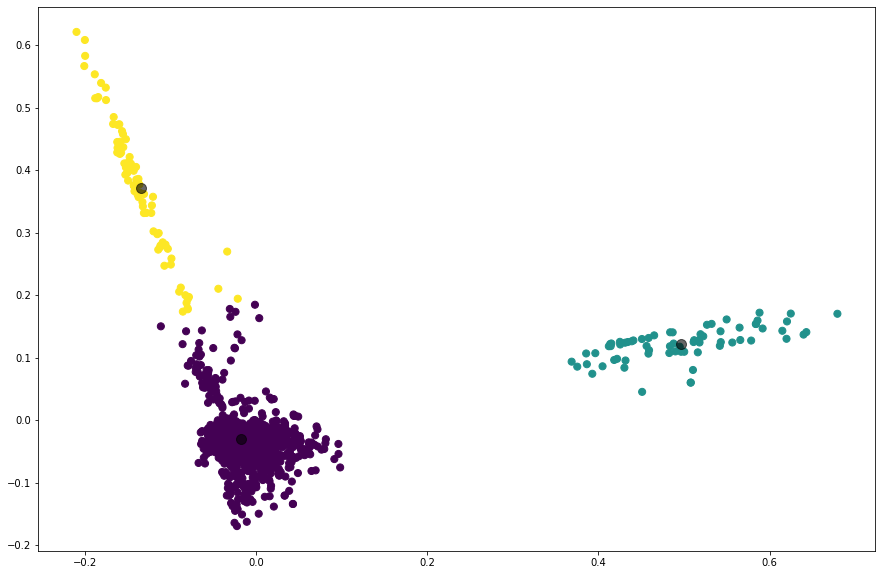

In [78]:
kmeans = KMeans(n_clusters= 3, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(y)
prediction_3 = kmeans.predict(y)

plt.figure(figsize=(15,10))
plt.scatter(y[:, 0], y[:, 1],c=prediction_3 ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=100, alpha=0.6);

## Four Clusters

CPU times: user 47.8 ms, sys: 332 µs, total: 48.1 ms
Wall time: 47.4 ms


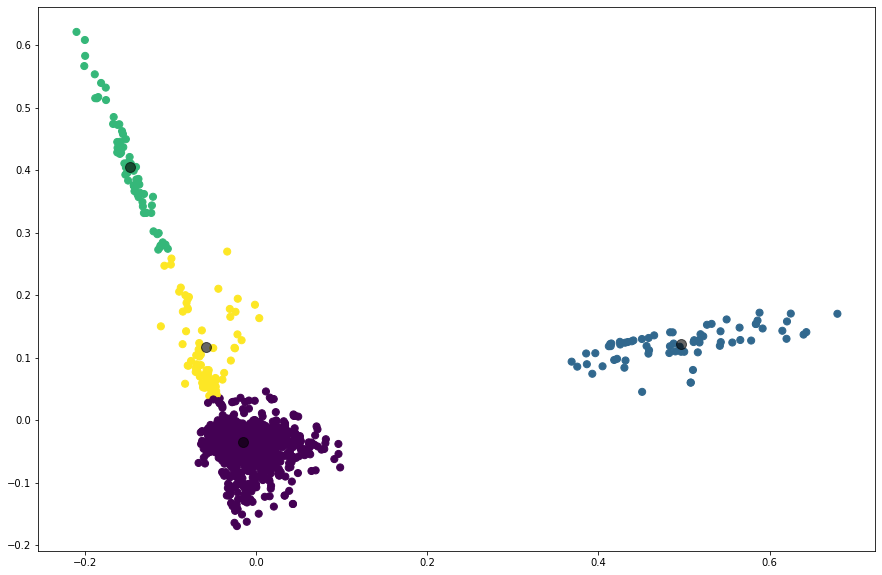

In [79]:
kmeans = KMeans(n_clusters= 4, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(y)
prediction_4 = kmeans.predict(y)

plt.figure(figsize=(15,10))
plt.scatter(y[:, 0], y[:, 1],c=prediction_4 ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=100, alpha=0.6);

## Five Clusters

CPU times: user 54.8 ms, sys: 0 ns, total: 54.8 ms
Wall time: 54.4 ms


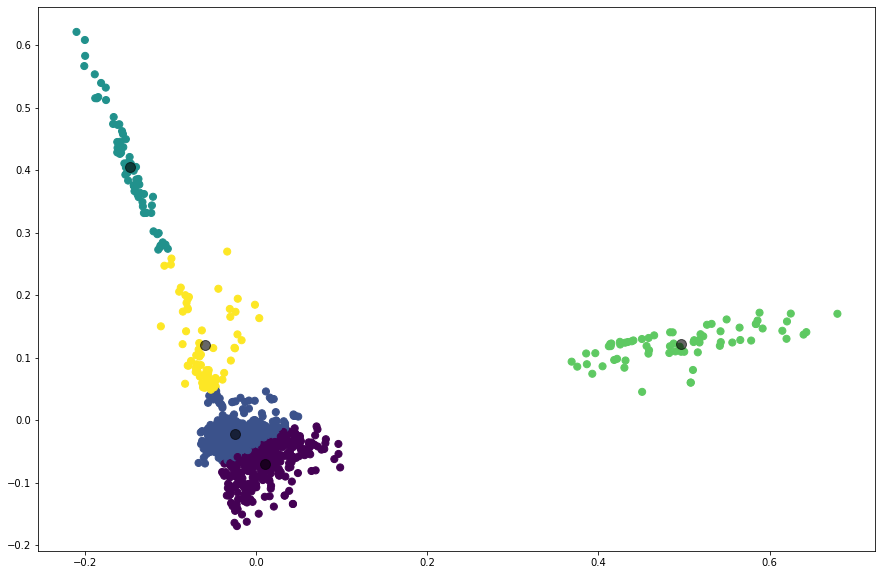

In [80]:
kmeans = KMeans(n_clusters= 5, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(y)
prediction_5 = kmeans.predict(y)

plt.figure(figsize=(15,10))
plt.scatter(y[:, 0], y[:, 1],c=prediction_5 ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=100, alpha=0.6);

In [0]:
silhouette_avg_3 = silhouette_score(y, prediction_3)
silhouette_avg_4 = silhouette_score(y, prediction_4)
silhouette_avg_5 = silhouette_score(y, prediction_5)

In [82]:
print('Silhouette score for 3 clusters:' , (silhouette_avg_3))
print('Silhouette score for 4 clusters:', (silhouette_avg_4))
print('Silhouette score for 5 clusters:', (silhouette_avg_5))

Silhouette score for 3 clusters: 0.8536969406766707
Silhouette score for 4 clusters: 0.7030972109070078
Silhouette score for 5 clusters: 0.5047111607829928


The model with three clusters yields the best silhouette score, while 4 clusters is not too far behind. The results from clustering might tell us how to categorize the products.  


The clusters could improve recommendations for customers. If a customer is given 10 recommendations for products all contained in one category, it might be less appealing. By selecting products from each cluster, the customer is more likely to be given a wider range of products. By providing variety, the products are more exciting and more likely to make a sale. 

At this point, recommendations will be based off of the supervised learning algorithm, Alternating Least Squares. In future work I would incorporate the labels produced by clustering. 

# Exploratory Analysis-Ratings

Summary statics and sql queries are used to answer to get a better understanding of the ratings column of the dataset. 

In [0]:
ratings_with_titles.registerTempTable('rev')

In [84]:
#number of total reviews
number_of_reviews = sqlContext.sql('SELECT count(rating) from rev').collect()[0]
print('The total number of reviews is %d' % number_of_reviews)

#number of unique products
number_of_products = sqlContext.sql('select count(distinct productID) as num_of_products from rev').collect()[0]
print('The number of distinct products is %d' % number_of_products)

#number of unique reviewers
number_of_reviewers = sqlContext.sql('select count(distinct reviewerID) as num_of_reviewers from rev').collect()[0]
print('The number of distinct reviewers is %d' % number_of_reviewers)

#average number of reviews per reviewer
avg_reviews_per_reviewer = sqlContext.sql('select count(rating)/count(distinct reviewerID) as avg_num_reviews from rev').collect()[0]
print('The average number of reviews per reviewer is %d' % avg_reviews_per_reviewer)

#average number of reviews per product
avg_reviews_per_product = sqlContext.sql('select count(rating)/count(distinct productID) as avg_product_reviews from rev').collect()[0]
print('The average number of reviews per product is %d' % avg_reviews_per_product)

The total number of reviews is 27823
The number of distinct products is 1541
The number of distinct reviewers is 3817
The average number of reviews per reviewer is 7
The average number of reviews per product is 18


In [85]:
#Number of reviews by reviewer ID, starting with the customer with the highest number of reviews
ratings_per_reviewer = sqlContext.sql('select reviewerID, count(reviewerID) as number_of_reviews from rev group by reviewerID order by count(reviewerID) desc')
ratings_per_reviewer.show()

+--------------+-----------------+
|    reviewerID|number_of_reviews|
+--------------+-----------------+
|A2V5R832QCSOMX|               90|
| AQY5XBYSENNZQ|               90|
| AHN86VFJIJ2JP|               79|
|A2OW1FKQFPIA5D|               78|
|A3091RP0SPZLMN|               77|
|A2YKWYC3WQJX5J|               60|
|A2LW5AL0KQ9P1M|               58|
|A2GJX2KCUSR0EI|               54|
| AJX9A4Q19UTJU|               52|
| AW6J9IILGOZY3|               52|
|A15T9G38F589KM|               51|
|A2R1HUYHXV7H18|               51|
|A2ZY49IDE6TY5I|               51|
| AOEUN9718KVRD|               50|
|A19KLUZ1XD3SRN|               49|
| AJRFZ0VZ0LD26|               47|
| AMB2Z4FMDBWQY|               44|
|A2503LT8PZIHAD|               43|
| AENH50GW3OKDA|               42|
|A1QBOC76MIOJYP|               42|
+--------------+-----------------+
only showing top 20 rows



In [87]:
#Number of reviews per product, starting with the most highly reviewed product
sqlContext.sql('select title, count(title) as reviews_per_product from rev group by title order by count(title) desc').show(truncate=False)

+--------------------------------------------------------------------------------------------+-------------------+
|title                                                                                       |reviews_per_product|
+--------------------------------------------------------------------------------------------+-------------------+
|essie Nail Color Polish                                                                     |3504               |
|Creative Nail Design Shellac UV Color Coat, 25 Ounce                                        |776                |
|TOPPIK Hair Building Fibers                                                                 |378                |
|HOT TOOLS Professional 24k Gold Extra-Long Barrel Curling Iron/Wand for Long Lasting Results|244                |
|Dermablend Cover Creme Full Coverage Foundation with SPF 30, 1 Oz                           |238                |
|Dermablend Intense Powder High Coverage Foundation                             

In [0]:
ratings_per_reviewer.registerTempTable('counts')

In [89]:
#How many reviewers have a specific number of ratings?
sqlContext.sql('select number_of_reviews, count(number_of_reviews) from counts group by number_of_reviews order by number_of_reviews asc').show()

+-----------------+------------------------+
|number_of_reviews|count(number_of_reviews)|
+-----------------+------------------------+
|                1|                      22|
|                2|                     192|
|                3|                     396|
|                4|                     620|
|                5|                     715|
|                6|                     379|
|                7|                     199|
|                8|                     520|
|                9|                     151|
|               10|                     107|
|               11|                      67|
|               12|                      54|
|               13|                      44|
|               14|                      48|
|               15|                      35|
|               16|                      38|
|               17|                      28|
|               18|                      22|
|               19|                      15|
|         

### Insights


> The highest number of ratings for one reviewer is ***90***.


> The highest number of ratings for one product is ***3504***.


> The most common number of ratings per reviewer is between ***3 and 10***.









## Visualizations

### Rating Distribution

In [0]:
graph_df = ratings_with_titles.toPandas()

Text(0.5, 1.0, 'Distribution of product ratings')

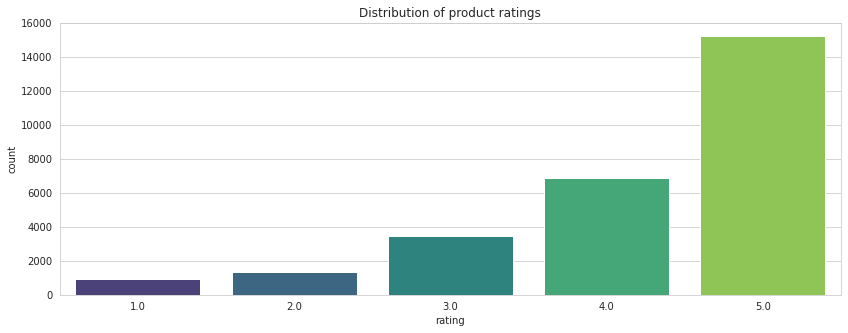

In [91]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
ax = sns.countplot(x="rating", data=graph_df, palette="viridis")
plt.title("Distribution of product ratings")

### Ratings per Reviewer

In [0]:
ratings_per_reviewer = ratings_per_reviewer.toPandas()

In [93]:
ratings_per_reviewer['number_of_reviews'].mean()

7.289232381451401

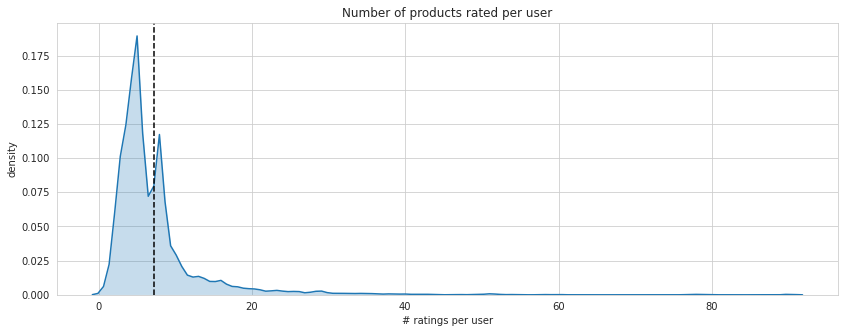

In [94]:
plt.figure(figsize=(14, 5))
ax = sns.kdeplot(ratings_per_reviewer['number_of_reviews'], shade=True, legend=False)
plt.axvline(ratings_per_reviewer['number_of_reviews'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of products rated per user")
plt.show()

## Preparing Data for Model Phase



> Numeric values are needed for the recommender model. Both productID 
and reviewerID are in string form, so both will be given an index.



In [0]:
users = ratings_with_titles.select("reviewerID").distinct().coalesce(1)

In [0]:
users = users.withColumn('reviewer_index', monotonically_increasing_id()).cache()

In [0]:
products = ratings_with_titles.select("productID").distinct().coalesce(1)

In [0]:
products = products.withColumn('product_index', monotonically_increasing_id()).cache()

In [0]:
idx_df = ratings_with_titles.join(users,'reviewerID', 'left').join(products, 'productID', 'left')

In [100]:
idx_df.show()

+----------+--------------------+------+--------------------+--------------+-------------+
| productID|          reviewerID|rating|               title|reviewer_index|product_index|
+----------+--------------------+------+--------------------+--------------+-------------+
|B0001EKVGS|       AC2BHILNGQJ2Q|   5.0|jane iredale Pure...|           101|            0|
|B0001EKVGS|       AL8SSEC9U7PT1|   5.0|jane iredale Pure...|           292|            0|
|B0001EKVGS|A0488385844WNV2OWO9X|   5.0|jane iredale Pure...|           494|            0|
|B0001EKVGS|A0488385844WNV2OWO9X|   4.0|jane iredale Pure...|           494|            0|
|B0001EKVGS|       ACVS8I9T74237|   4.0|jane iredale Pure...|           563|            0|
|B0001EKVGS|      A3RNP5X8ZGZIEI|   3.0|jane iredale Pure...|           603|            0|
|B0001EKVGS|       ASGIVOW34XNQS|   5.0|jane iredale Pure...|           643|            0|
|B0001EKVGS|      A1HIW8QEDZ26KA|   4.0|jane iredale Pure...|           772|            0|

In [101]:

idx_df.count()

27823

In [0]:
#Save cleaned up dataframe to use in model selection phase
idx_df.write.format('json').save('/content/gdrive/My Drive/lux_beauty_index.json')